# Functional Connectivity
This notebook quantify functional connectivities at sensor level.

It expects preprocessed data in .fif mne format.

It produces a dataframe of functional connectivity.

# Setup

In [1]:
# Import necessary modules
import mne
import pandas as pd
import numpy as np
import os.path as op
import matplotlib.pyplot as plt
from mne_connectivity import spectral_connectivity_epochs, spectral_connectivity_time, envelope_correlation
from mne_connectivity.viz import plot_connectivity_circle

from pathlib import Path

# define some useful functions

def insert_fcz_pos(epochs):
    '''
    add FCz position based on channels CPz
    (Their positions are the same, only y-axis value is different)
    '''
    import copy
    ch_names = copy.deepcopy(epochs.info['ch_names']) 
    [ch_names.remove(i) for i in ['ECG', 'EOG1', 'EOG2']]
    pos_array = epochs._get_channel_positions()
    
    pos_fcz = pos_array[ch_names.index('CPz')] * np.array([1, -1, 1])
    pos_array = np.insert(pos_array, 58, pos_fcz, axis=0)
    pos_array = np.delete(pos_array, -1, axis=0)
    
    pos_dict = dict(zip(ch_names, pos_array))
    pos = mne.channels.make_dig_montage(pos_dict)
    
    return pos

def _epochs_to_continuous(epochs_csd):
    array = epochs.get_data()
    shape = array.shape
    init = np.zeros(shape[1:])
    for i in range(shape[0]):
        init = np.hstack((init, array[i]))

    raw = np.delete(init, np.s_[:shape[2]], 1)

    return raw

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Surface Laplacian for connectivity analysis

Reading /Users/yeganeh/Codes/otka-preprocessing/data/clean_data/sub-02_ses-01_task-baseline1_proc-clean_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     999.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
266 matching events found
No baseline correction applied
0 projection items activated
Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 0.0 mm
Origin device coordinates:    0.0 -0.0 0.0 mm


/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_43132/890183543.py:9: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(pos)


Using matplotlib as 2D backend.


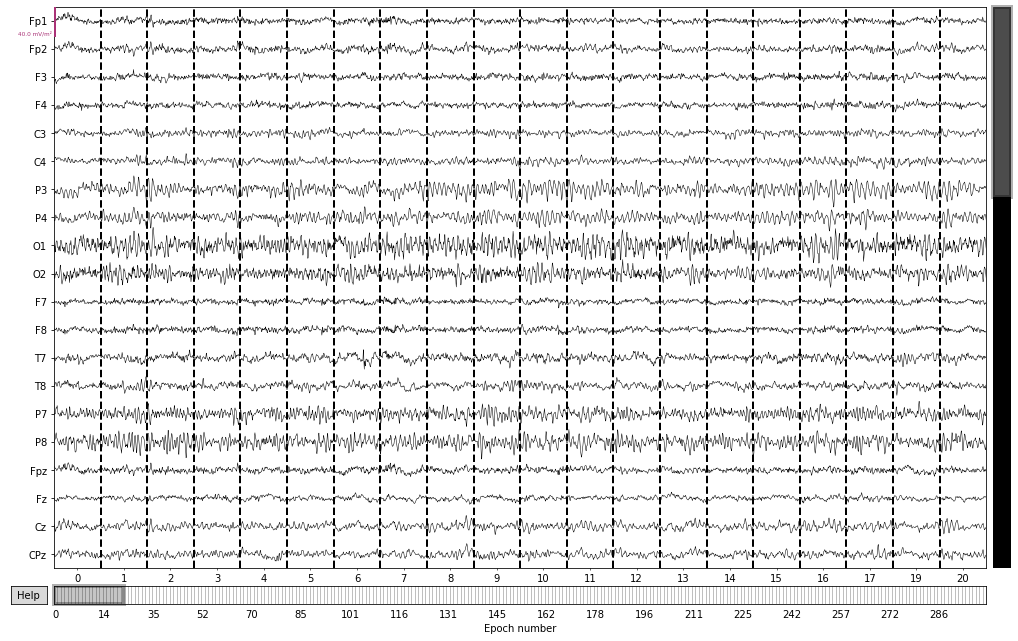

In [2]:
n_sub = '02'
task = 'baseline1'
path = 'data/clean_data'
epo_name = f'sub-{n_sub}_ses-01_task-{task}_proc-clean_epo.fif'
dir = op.join(path, epo_name)
# open clean epochs
epochs = mne.read_epochs(dir)
pos = insert_fcz_pos(epochs)
epochs.set_montage(pos)

# epochs = epochs.pick_types(eeg=True)
epochs_csd = mne.preprocessing.compute_current_source_density(epochs)
epochs_csd.plot(n_epochs=20)
plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows


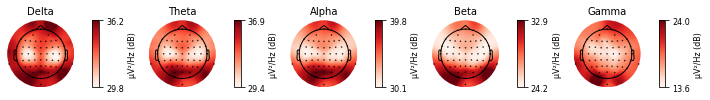

    Using multitaper spectrum estimation with 7 DPSS windows


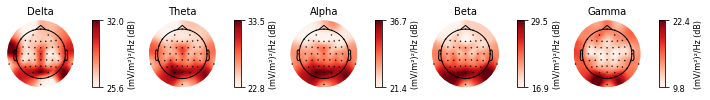

In [4]:
bands = [(0, 4, 'Delta'), (4, 8, 'Theta'), (8, 12, 'Alpha'),
         (12, 30, 'Beta'), (30, 45, 'Gamma')]
epochs.plot_psd_topomap(bands=bands)
epochs_csd.plot_psd_topomap(bands=bands)
plt.show()

# FC

In [ ]:
# create a continuous signal
raw = _epochs_to_continuous(epochs)

ch_names = epochs.ch_names
info = mne.create_info(ch_names, ch_types='eeg', sfreq=1000)
raw_csd = mne.io.RawArray(raw, info)
raw_csd.set_channel_types({
    'ECG': 'ecg',                  
    'EOG1': 'eog',
    'EOG2': 'eog'
    })

# open raw
from mne_bids import BIDSPath, read_raw_bids
bids_path = BIDSPath(
        subject='01',
        session='01',
        task='baseline1',
        root='data/BIDS_data'
        )
raw = read_raw_bids(bids_path, extra_params={'preload': True}, verbose=False)
            
foi = np.array([[4, 8], [8,12]]) # frequencies of interest

In [ ]:
# Functional connectivity over time
freqs = np.arange(20, 30, 1)
con = spectral_connectivity_time(
        epochs, sfreq=1000, freqs=freqs, mode='multitaper')

In [ ]:
# Functional connectivity over epochs
fmin = (4., 8.) # lower limits of the frequency ranges
fmax = (8., 12.) # upper limits of the frequency ranges
con = spectral_connectivity_epochs(
        epochs_csd, method='pli', sfreq=1000, mode='cwt_morlet', fmin=fmin, 
        fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=-1, verbose=0)
con.get_data().shape

In [ ]:
# measuring functional connectivity using envelope correlation
# open data
path = 'data/clean_data'
# define the frequency bands
bands = {'theta': (4, 8),
        #  'alpha': (8, 12)
         }
subjects = [f'{i:02}' for i in range(1, 51)]
tasks = ['baseline1']
X_conn = np.zeros((1,59,59))

for n_sub in subjects:
  for task in tasks:
    epo_name = f'sub-{n_sub}_ses-01_task-{task}_proc-clean_epo.fif'
    dir = op.join(path, epo_name)
    # open clean epochs
    epochs = mne.read_epochs(dir)
    # get eeg channels
    epochs = epochs.pick_types(eeg=True)
    for k, v in bands.items():
      epoch_temp = epochs.copy().filter(l_freq=v[0], h_freq=v[1], method='fir', n_jobs=-1, verbose=0)
      con = envelope_correlation(epoch_temp, verbose=0)
      con = con.get_data(output='dense').mean(0)[:,:,0]
      X_conn = np.append(X_conn,
                         np.array([con]),
                         axis=0)
      # con_dict[n_sub+'_'+task+'_'+k] = con
X_conn = np.delete(X_conn, 0, 0)

In [137]:
_X_conn = np.array([xi[np.triu_indices(X_conn.shape[-1], k=0)] for xi in X_conn])

conn_labels = pd.DataFrame(columns=[f'{i}' for i in range(59)], index=[f'{i}' for i in range(59)])
conn_labels = conn_labels.apply(lambda x: x.index + '\N{left right arrow}' + x.name)
conn_labels = conn_labels.values[np.triu_indices(conn_labels.shape[0], k=0)]
conn_df = pd.DataFrame(_X_conn, columns=conn_labels)

In [147]:
identicals_col = [f'{i}\N{left right arrow}{i}' for i in range(59)]
conn_df.drop(identicals_col, axis=1, inplace=True)
conn_df


,0↔1,0↔2,0↔3,0↔4,0↔5,0↔6,0↔7,0↔8,0↔9,0↔10,...,54↔55,54↔56,54↔57,54↔58,55↔56,55↔57,55↔58,56↔57,56↔58,57↔58
0,0.240171,0.246053,0.237661,0.250009,0.250075,0.235529,0.246661,0.233193,0.253486,0.243811,...,0.232220,0.265115,0.238942,0.263701,0.258485,0.265460,0.231256,0.254768,0.246946,0.246594
1,0.248024,0.237156,0.243110,0.259237,0.253886,0.243373,0.245419,0.249939,0.252256,0.237554,...,0.233080,0.241965,0.245571,0.243444,0.241793,0.259854,0.254324,0.249622,0.243781,0.240407
2,0.246538,0.259622,0.243379,0.249040,0.255165,0.243541,0.261110,0.244174,0.246950,0.243312,...,0.255101,0.238959,0.248719,0.240550,0.251593,0.233020,0.244148,0.242503,0.239155,0.239420
3,0.250616,0.266347,0.274902,0.271182,0.265238,0.260895,0.253268,0.248565,0.259603,0.255966,...,0.255804,0.253924,0.257530,0.265024,0.257420,0.263957,0.246363,0.258936,0.247555,0.246153
4,0.242592,0.250404,0.252397,0.247420,0.239442,0.263676,0.251414,0.245056,0.248550,0.243706,...,0.236599,0.246352,0.250148,0.248509,0.237294,0.243800,0.246499,0.228305,0.237754,0.237895
5,0.251376,0.245577,0.257317,0.266874,0.266299,0.267534,0.257288,0.279628,0.274885,0.270270,...,0.260328,0.294754,0.275179,0.275501,0.260935,0.332795,0.258759,0.261132,0.265100,0.257991
6,0.250784,0.248440,0.249731,0.240108,0.241483,0.242066,0.244453,0.244567,0.230886,0.255338,...,0.245014,0.255981,0.261255,0.259025,0.218469,0.243076,0.240344,0.235798,0.259107,0.243109
7,0.240270,0.235727,0.247812,0.236843,0.263614,0.241066,0.244689,0.250650,0.255249,0.242794,...,0.253358,0.254963,0.242949,0.230233,0.258847,0.268037,0.241878,0.258004,0.245848,0.251302
8,0.243321,0.249000,0.251093,0.238833,0.248379,0.249465,0.237329,0.243930,0.237106,0.253355,...,0.243837,0.241791,0.230658,0.236537,0.239687,0.234959,0.244337,0.232575,0.242874,0.238967
9,0.256280,0.253180,0.269655,0.267785,0.246968,0.275674,0.246286,0.243023,0.246699,0.260847,...,0.240602,0.254409,0.246809,0.261779,0.245524,0.248113,0.254828,0.250653,0.261257,0.254737


In [259]:
# avraging over all frequency matrices
freqs = {0:'theta', 1:'alpha'}
avgs = {}

for i in range(2):
    sum =  np.array([0])
    for key in con_dict.keys():
        sum = sum + con_dict[key].get_data(output='dense')[:,:,i]
    
    avgs[freqs[i]] = sum / len(con_dict.keys())

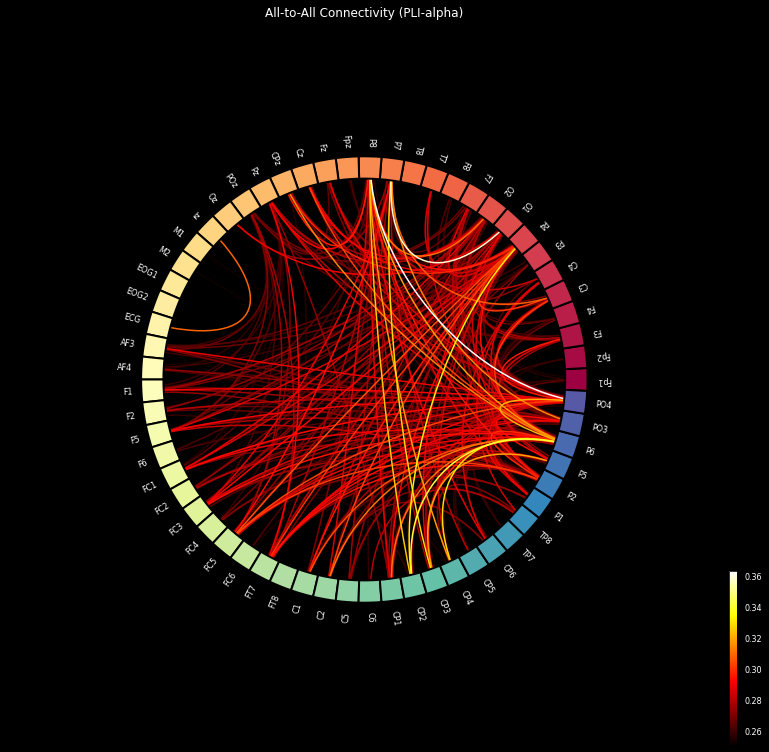

(<Figure size 1152x1152 with 2 Axes>,
 <PolarAxesSubplot:title={'center':'All-to-All Connectivity (PLI-alpha)'}>)

In [268]:
fig = plt.figure(num=None, figsize=(16, 16), facecolor='black')
plot_connectivity_circle(avgs['alpha'], epoch.ch_names, n_lines=300,
                        #  node_angles=node_angles, node_colors=node_colors,
                         title='All-to-All Connectivity (PLI-alpha)', fig=fig)

In [ ]:
fig = plt.figure(num=None, figsize=(16, 16), facecolor='black')
plot_connectivity_circle(avgs['theta'], epoch.ch_names, n_lines=300,
                        #  node_angles=node_angles, node_colors=node_colors,
                         title='All-to-All Connectivity (PLI)', fig=fig)

For replication of previous works:

In high hypnotizable individuals the anterior connectivity decreases, while the posterior connectivity increases.
High hypnotizable participants showed reduced connectivity between frontal-parietal, frontal-central nodes and within frontal cortex however connectivity increased in central-parietal cortex.

The frequency band of these effects were different across studies.

### Represent in graph
In graph theory, networks can be represented as matrices or as graphs. 
MST is a graph that vertices are connected together using a subset of edges, without the construction of any cycles. (MST measures: Degree (k) Number of neighbors of each node, Diameter (d) Longest path between nodes in MST structure, Eccentricity (E) Longest path between each node and any other nodes. Leaf number (L) Number of nodes with a degree of one Radius (R) Minimum value of eccentricity of vertices. Betweenness centrality (BC) Amount of centrality of a node in the graph. Hierarchy (H))




# Graph Neural Network

Deep learning is able to find representations in the data and differentiate between conditions in a way that is not evident from other methods. In particular, "Convolutional neural networks (CNNs) are widely used to recognize the user’s state through electroencephalography (EEG) signals." (Liu et al., 2022)

[review on the emotional recognition and mental workload studies. here I can also review the studies that used GNN to study naturalistic stimuli]

Models's ingredient: Input, output, function, loss

### Significance
- introduce the first GNN model trained on hypnosis data.
- compare training network with raw and preprocessed data.
- find the critical frequency band.

### intrepretations
- what is the "critical frequency band"? in which frequency bands our model has the best performance? "This indicates that lower beta features and relatedad-jacent matrix are valid representations for the emotions of brainas compared to others." [Now, it occured to me that studying psds features alone would not be the best practice (specially when we divide them into different brain areas. what's the meaning of that? Brain neurons are oscillating in specific frequency to send or recieve information, so what we want to know is which brain areas in which frequency bands are transforming information. Knowing the psds alone can gives us some infomation about brain activity during hypnosis, but it won't relate the whole story of the brain functioning during hypnosis which is my end goal in my disseration)]. In the other words, I can only investigate the relevance and importance of psd features by putting them in connectivity framework.

### comparing the psd plot of the raw data with preprocessed data

Extracting parameters from data/BIDS_data/sub-10/ses-01/eeg/sub-10_ses-01_task-induction1_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 330934  =      0.000 ...   330.934 secs...
Reading events from data/BIDS_data/sub-10/ses-01/eeg/sub-10_ses-01_task-induction1_events.tsv.
Reading channel info from data/BIDS_data/sub-10/ses-01/eeg/sub-10_ses-01_task-induction1_channels.tsv.
Not setting metadata
Not setting metadata
330 matching events found
No baseline correction applied
0 projection items activated
Loading data for 330 events and 1000 original time points ...
0 bad epochs dropped
Reading /Users/yeganeh/Codes/otka-preprocessing/data/clean_data/sub-10_ses-01_task-induction1_proc-clean_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     999.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
199 matching events found
No baseline correction applied
0 projection items activated


/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_22480/3510489960.py:11: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['ECG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(path, verbose=False, misc=['ECG'])
/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_22480/3510489960.py:13: RuntimeWarning: The unit for channel(s) ECG has changed from NA to V.
  raw.load_data().set_channel_types({'ECG': 'ecg'})
/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_22480/1482233064.py:12: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epoch_raw.set_montage(pos)
/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_22480/1482233064.py:12: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['EOG1', 'EO

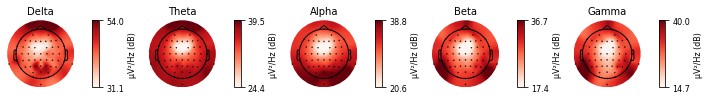

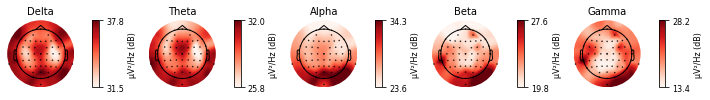

In [85]:
n_sub = '10'
task = 'induction1'

bids_path = BIDSPath(subject=n_sub,
                        session='01',
                        task=task,
                        root='data/BIDS_data')
raw = read_raw_bids(bids_path, extra_params={'preload': True}, verbose=False)

epoch_raw = mne.make_fixed_length_epochs(raw, duration=1, preload=True)
pos = _make_montage()
epoch_raw.set_montage(pos)

path = 'data/clean_data'
epo_name = f'sub-{n_sub}_ses-01_task-{task}_proc-clean_epo.fif'
dir = op.join(path, epo_name)

# open clean epochs
epoch_clean = mne.read_epochs(dir)

bands = [(0, 4, 'Delta'), (4, 8, 'Theta'), (8, 12, 'Alpha'),
         (12, 30, 'Beta'), (30, 45, 'Gamma')]

mne.viz.plot_epochs_psd_topomap(epoch_raw, bands=bands, ch_type='eeg', dB=True, bandwidth=2, verbose=0)

mne.viz.plot_epochs_psd_topomap(epoch_clean, bands=bands, dB=True, ch_type='eeg', bandwidth=2, verbose=0)
plt.show()